In [2]:
import glob
import os

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scanpy.api as sc

%matplotlib inline

/home/ubuntu/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
gene_cell_table = pd.read_csv('s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/results/ashleys_gct.csv', index_col=0)
print(gene_cell_table.shape)
gene_cell_table.head()

In [ ]:
gene_cell_table.columns = gene_cell_table.columns.map(lambda x: x.split('.')[0])
gene_cell_table.head()

In [ ]:
X = gene_cell_table.T
print(X.shape)
X.head()

In [ ]:
results_file = '/mnt/data/lung_cancer.h5ad'


sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

In [ ]:
sc.logging.print_memory_usage()

In [ ]:
from anndata import AnnData

In [ ]:
obs = pd.DataFrame(index=X.index)
var = pd.DataFrame(index=X.columns)

In [ ]:
lung_cancer = AnnData(X.values, obs=obs, var=var)
lung_cancer

In [ ]:
lung_cancer.var_names_make_unique()
lung_cancer

In [ ]:
sc.pp.filter_cells(lung_cancer, min_genes=500)
sc.pp.filter_genes(lung_cancer, min_cells=3)

In [ ]:
lung_cancer

In [ ]:
adata = lung_cancer

In [ ]:
mito_genes = [name for name in adata.var_names if name.startswith('Mt')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata = adata[adata.obs['n_genes'] < 10000, :]
adata

In [ ]:
# adata.raw = sc.pp.log1p(adata, copy=True)

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

In [ ]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=10, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [ ]:
filter_result

In [ ]:
adata = adata[:, filter_result.gene_subset]

In [ ]:
adata

In [ ]:
adata.obsm

In [ ]:
# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
adata.write(results_file)


In [ ]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata)


In [ ]:
adata.write(results_file)
adata

In [ ]:
n_pcs = 4

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [ ]:
sc.tl.louvain(adata)
sc.pl.umap(adata, color='louvain')

In [ ]:
range(3)

In [ ]:
%%time

sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.logging.print_memory_usage()


In [ ]:
sc.__version__

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=10)

In [ ]:
top_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
top_genes.head()

In [ ]:
top_genes_top_per_cluster = np.unique(top_genes.iloc[:, :2].values.flat)
len(top_genes_top_per_cluster)

In [ ]:
from itertools import islice

['AGR2' 'AKAP12' 'ALDH1L1' 'ANKS4B' 'APOBEC3G' 'APOBEC3H' 'ARNT2' 'ASPM'
 'ATP6V0A4' 'AXL' 'BEAN1' 'BEX1' 'BRWD1-IT2' 'C12orf75' 'C16orf54'
 'C21orf62-AS1' 'CA12' 'CCDC13' 'CCDC183-AS1' 'CCL4L1']


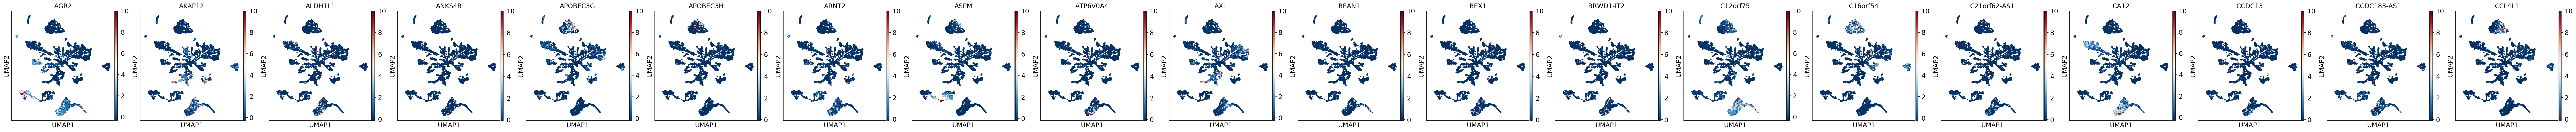

['CCL5' 'CCND2' 'CD2' 'CD247' 'CD27' 'CD28' 'CD3D' 'CD3G' 'CD40LG' 'CD5'
 'CD52' 'CD53' 'CD6' 'CD7' 'CD8A' 'CD8B' 'CD96' 'CFAP46' 'CLDN9' 'CLEC2D']


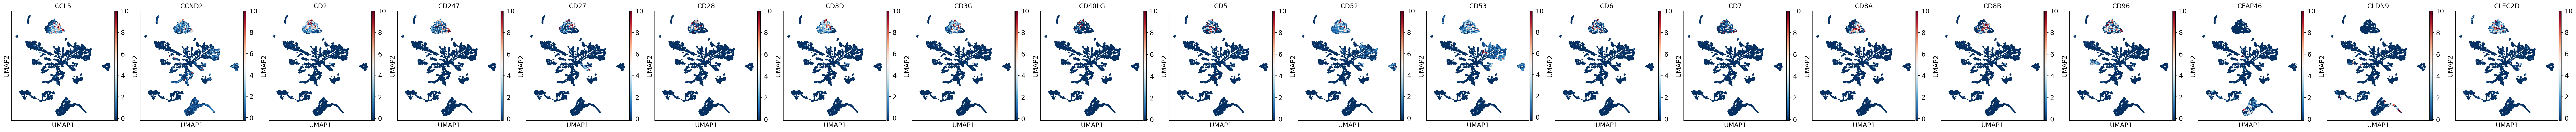

['CLU' 'COL18A1' 'COL4A1' 'COL4A3' 'CORO1A' 'CPVL' 'CRYM' 'CST7'
 'CTD-2297D10.2' 'CTLA4' 'CTSW' 'CXCR3' 'CXCR4' 'CXCR6' 'CYB5D2' 'CYP27A1'
 'CYTIP' 'CYYR1' 'DCBLD2' 'DNAAF3']


KeyboardInterrupt: 

Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/ubuntu/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 636, in _abort_queues
    self._abort_queue(stream)
  File "/home/ubuntu/anaconda/lib/python3.6/site-packages/ipyk

In [ ]:
chunksize = 4

n_chunks = int(np.ceil(len(top_genes_top_per_cluster)/chunksize))

for i in range(n_chunks):
    start = i*chunksize
    stop = i*chunksize + chunksize
    genes = top_genes_top_per_cluster[start:stop]
    print(genes)
    
    sc.pl.umap(adata, color=genes)

In [42]:
sc.pl.umap(adata, color=top_genes_top_per_cluster)

ValueError: Image size of 134000x640 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 67000x320 with 400 Axes>